# Analysis of the floe size distribution
The Ice Floe Tracker (IFT) identifies sea ice floes in optical satellite images. Challenges to floe observation include cloud cover, indistinct floe boundaries, and floe sizes at or below the imager resolution. As a result of these challenges the floes identified by the IFT represent a sample of available floes. Since the original submission, we have revised our data quality control procedure, increasing the number of available floes for FSD analysis. In the original paper, we carried out a simple analysis of the FSD by binning all the images together. With the updated dataset, we improve upon our original method by calculating best fit alpha parameters for every image with at least 100 identified floes.



We developed a new approach to floe shape extraction, making a higher quality set of shapes. While we feel that our original approach is informative for connecting the FSD and velocity, we agree with the reviewers that a more thorough approach is warranted.

Calculating FSD per image instead of overall - higher FSD value, can see a seasonal trend


The IFT data does not represent full enumeration of the FSD. Rather, we are looking at some sort of random sample of the FSD and we are estimating it over multiple days. 
- powerlaw PDF uses logarithmic binning
- CDFs and CCDFs do not require binning

powerlaw goodness of fit


In [1]:
#Import everything
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import csv
import powerlaw
import os
import proplot as pplt
from datetime import datetime

In [512]:
temp = []
for year in range(2003, 2021):
    temp.append(pd.read_csv('../data/floe_tracker/ift_floe_property_tables/with_nsidc/ift_floe_properties_{y}.csv'.format(y=year),
                            parse_dates=True))
df = pd.concat(temp)
df['datetime'] = pd.to_datetime(df['datetime'].values)
df = df.loc[(df.datetime.dt.dayofyear >= 91) & (df.datetime.dt.dayofyear <= 258)]

In [513]:
df['perim_km'] = df.perimeter*.25
df['area_km'] = df.area*.25*.25
df['area_adj_km'] = (np.sqrt(df.area) + 6)**2*.25*.25 # 6 pixel shift minimizes error against manual
df['doy'] = df.datetime.dt.dayofyear
df['year'] = df.datetime.dt.year

# Number of floes detected per image
The number of floes detected per image evolves through the year, with one peak in mid April and a secondary peak in June.

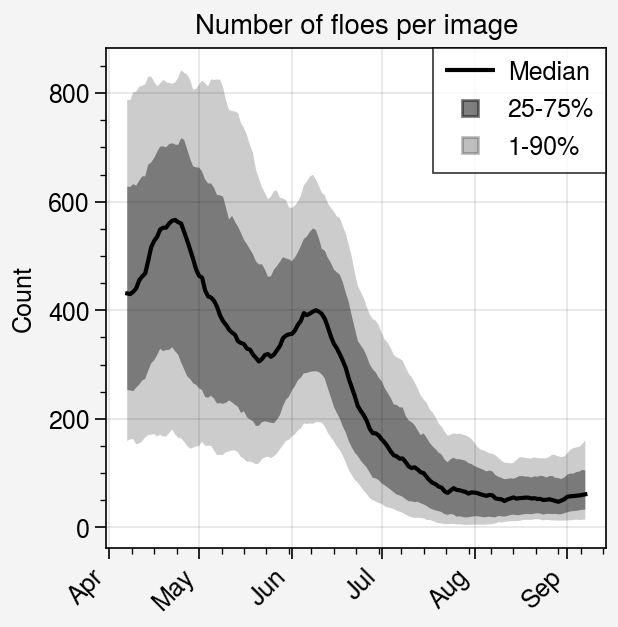

In [514]:
count_range = df.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
fig, ax = pplt.subplots()
smoothed_count_range = count_range.T.rolling(15, center=True).mean()
ax.plot(smoothed_count_range[0.5], color='k',
        shadedata=[smoothed_count_range[0.25],
                   smoothed_count_range[0.75]],
       fadedata=[smoothed_count_range[0.1],
                 smoothed_count_range[0.9]])
dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax.format(xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr], xrotation=45)
h = []
for alpha, ls, m in zip([1, 0.5, 0.25], ['-', '', ''], ['', 's', 's']):
    h.append(ax.plot([],[],color='k', alpha=alpha, ls=ls, m=m))
ax.legend(h, ['Median', '25-75%', '1-90%'], ncols=1, loc='ur')
ax.format(ylabel='Count', xlabel='', title='Number of floes per image')

The floe size distribution in the overall sample is useful for understanding what data we have access to. We want to see the number per year and the variation in the number across all the years, as well as the data density per month.

The figure below is showing how the FSD varies from image to image. The distribution is more narrow for the small floes than for large floes.

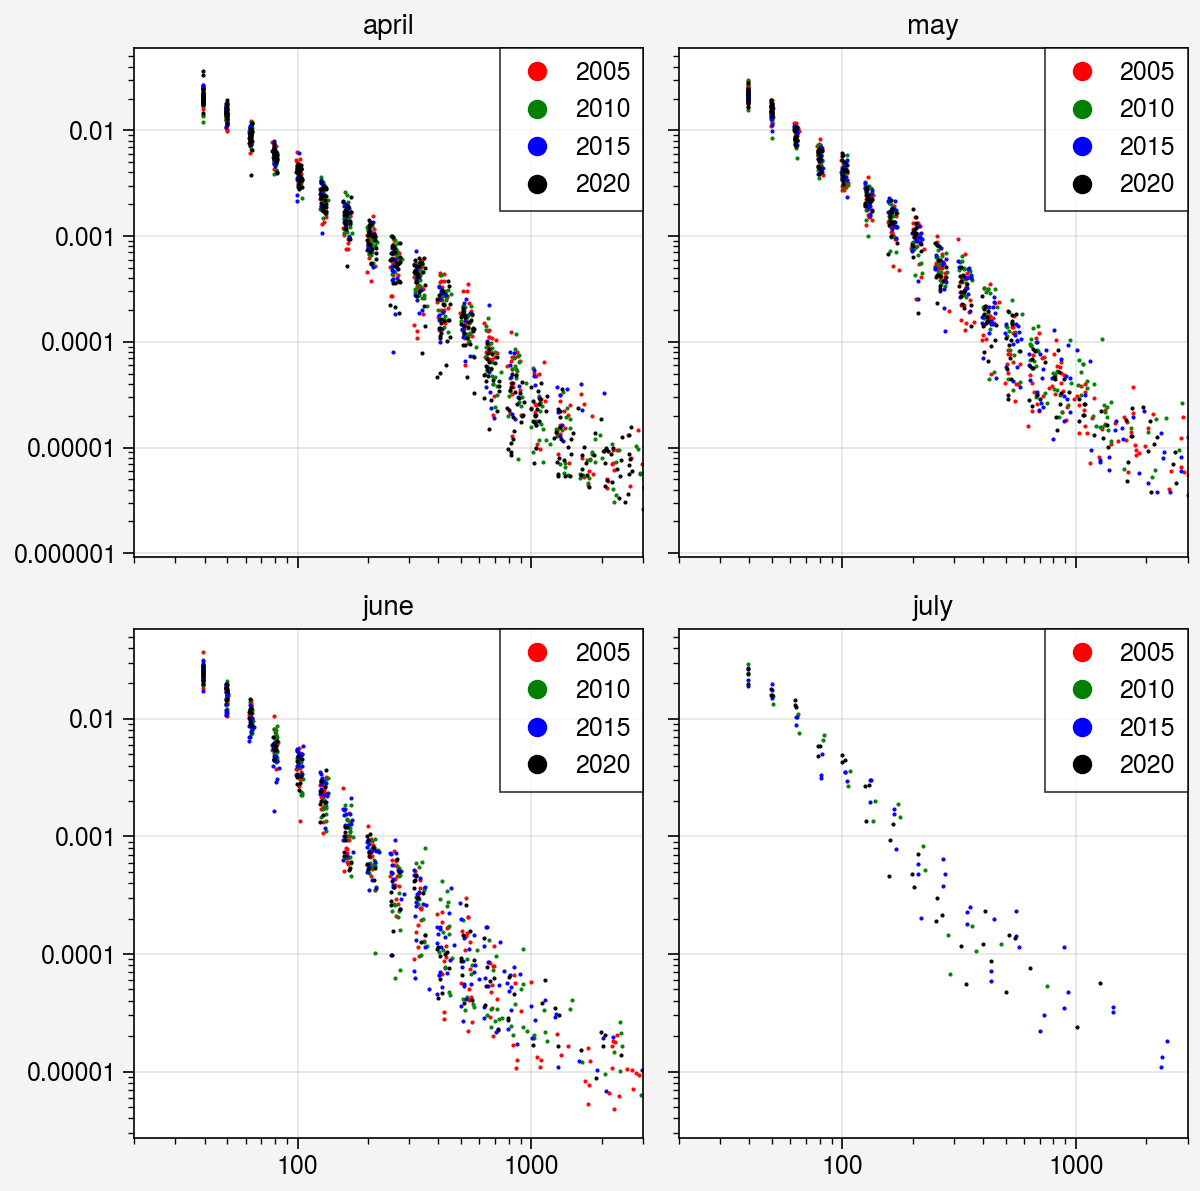

In [358]:
import warnings
warnings.simplefilter('ignore')
alphas = {}
fig, axs = pplt.subplots(width=6, ncols=2, nrows=2)
for ax, mindoy in zip(axs, [90, 120, 150, 180]):
    alphas[mindoy] = []
    for year, color in zip([2005, 2010, 2015, 2020], ['r', 'g', 'b', 'k']):
        for doy in range(mindoy, mindoy + 30): # April is 90-121, May is 122-152
            test = df.loc[(df.year == year) & (df.doy==doy)]
            if len(test) > 300:
                fit = powerlaw.Fit(test.area_km, xmin=35)
                alphas[mindoy].append(fit.power_law.alpha)
                bin_edges, probability = fit.pdf()
                bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
                ax.plot(bin_centers, probability, marker='.', lw=0, color=color, ms=1, label='')
    h = [ax.plot([],[], color=color, m='o', lw=0) for color in ['r', 'g', 'b', 'k']]
    l = [2005, 2010, 2015, 2020]
    ax.legend(h, l, ncols=1)
    ax.format(xscale='log', yscale='log', xlim=(20, 3000))
for ax, m in zip(axs, ['april', 'may', 'june', 'july']):
    ax.format(title=m)

# Model goodness-of-fit as a function of x min
The powerlaw function does have the option to find x-min on its own, however, we want consistency across all the data so we look the value that tends to minimize the difference between the data and the assumed distribution. We test both the power law and the lognormal distributions.

In [6]:
df_filtered = df.groupby('datetime').filter(lambda x: len(x) > 200)
date_sample = np.random.choice(np.unique(df_filtered.datetime), 100)

In [240]:
%%time
xmin_vals = np.arange(1, 75)
results_pl = []
results_ln = []

for date in date_sample:
    area = df.loc[df.datetime == date, 'area_adj_km']
    temp_pl = []
    temp_ln = []
    for x in xmin_vals:
        fit = powerlaw.Fit(area, xmin=x, fit_method='KS')
        temp_pl.append(fit.power_law.D)
        temp_ln.append(fit.lognormal.D)
    results_pl.append(pd.Series(temp_pl, index=xmin_vals))
    results_ln.append(pd.Series(temp_ln, index=xmin_vals))

In [66]:
large_groups = df.groupby('datetime').filter(lambda x: len(x) > 300)
dates = np.unique(large_groups['datetime'])
sample = np.random.choice(dates, 100)

In our dataset 732 images have more than 300 detected floes. Understanding the IFT results as a sample from the full set of ice floes, we test the minimum number of floes required to recover the power law slope of the full image. We test thresholds from 30 up to 300 floes and take 100 samples without replacement for each threshold size. We calculate the alpha parameter for each subsample and compute the relative error against the fit with all detected floes in the image. The test is carried out on a random sample of 100 of the 732 images.

In [70]:
# In our dataset, 732 images have more than 300 floes per image. To test 
# the erro
n = len(np.unique(large_groups.datetime))
len(sample)

100

In [ ]:
# Testing the threshold for number of floes per image
%%time
relative_error = {}
thresholds = np.arange(30, 301, 10)
n_resamples = 100
count = 0
for threshold in thresholds:
    print(threshold)
    relative_error[threshold] = []
    count=0
    for date in sample:
        count += 1
        sample_group = large_groups.loc[large_groups.datetime == date]
        area = sample_group.area_adj_km
        fit = powerlaw.Fit(area, xmin=xmin)
        alpha = fit.power_law.alpha
        
        for ii in range(n_resamples):
            area_resamp = sample_group.sample(threshold).area_adj_km
            fit = powerlaw.Fit(area_resamp, xmin=xmin)
            relative_error[threshold].append((fit.power_law.alpha - alpha) / alpha)
        if (count % 50) == 0:
            print(count)

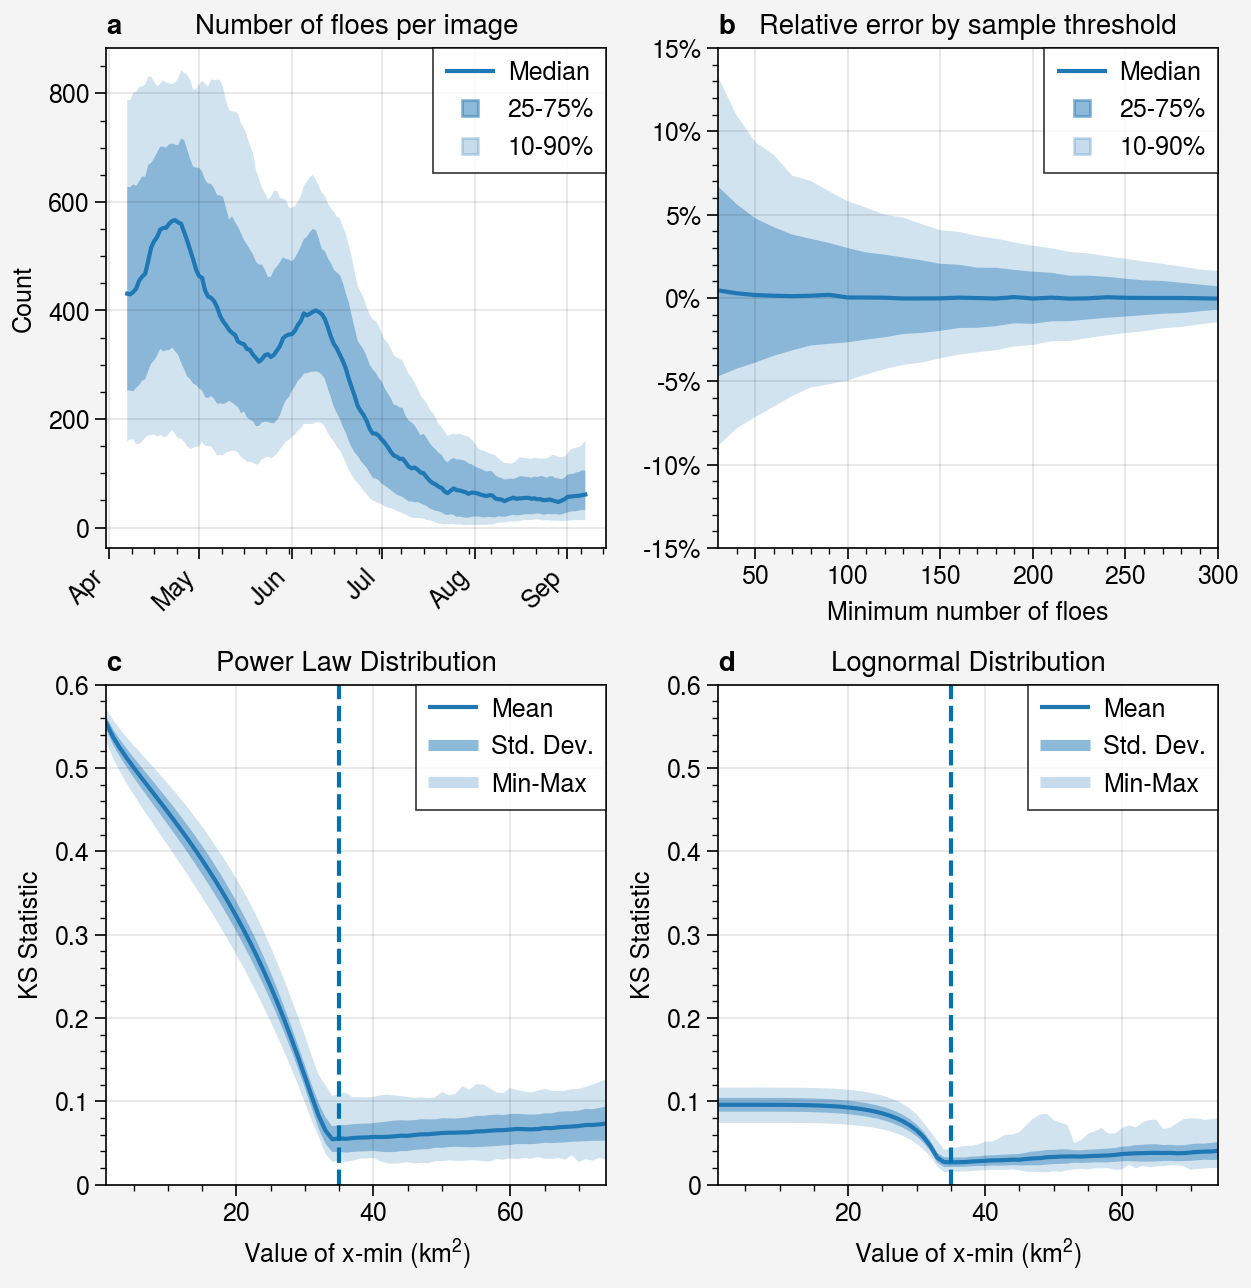

In [373]:
test_pl = pd.DataFrame(results_pl, index=date_sample)
test_ln = pd.DataFrame(results_ln, index=date_sample)
fig, axs = pplt.subplots(ncols=2, nrows=2, sharex=False, sharey=False)

count_range = df.groupby(['year', 'doy']).count().pivot_table(index='year',
                                                              columns='doy',
                                                              values='datetime').quantile(
                                                              [0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range = count_range.T.rolling(15, center=True).mean()
ax = axs[0,0]
ax.plot(smoothed_count_range[0.5], color='tab:blue',
        shadedata=[smoothed_count_range[0.25],
                   smoothed_count_range[0.75]],
       fadedata=[smoothed_count_range[0.1],
                 smoothed_count_range[0.9]])
dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax.format(xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr], xrotation=45, 
          ylabel='Count', xlabel='', title='Number of floes per image')

ax = axs[0,1]
ax.plot(pd.DataFrame(relative_error).median(axis=0), shadedata=[pd.DataFrame(relative_error).quantile(0.25, axis=0),
                                                                pd.DataFrame(relative_error).quantile(0.75, axis=0)],
        fadedata=[pd.DataFrame(relative_error).quantile(0.1, axis=0),
                                                                pd.DataFrame(relative_error).quantile(0.9, axis=0)], color='tab:blue')
ax.format(ylocator=[-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15], ylim=(-0.15, 0.15),
          yformatter=['-15%', '-10%', '-5%', '0%', '5%', '10%', '15%'], xlabel='Minimum number of floes')
ax.format(title='Relative error by sample threshold')


h = []
for alpha, ls, m in zip([1, 0.5, 0.25], ['-', '', ''], ['', 's', 's']):
    h.append(ax.plot([],[],color='tab:blue', alpha=alpha, ls=ls, m=m))
axs[0,0].legend(h, ['Median', '25-75%', '10-90%'], ncols=1, loc='ur')
axs[0,1].legend(h, ['Median', '25-75%', '10-90%'], ncols=1, loc='ur')

for ax, data, title in zip(axs[1,:], [test_pl, test_ln], ['Power Law', 'Lognormal']):
    ax.plot(data.mean(axis=0), shadedata=data.std(axis=0), fadedata=[data.min(axis=0), data.max(axis=0)], label='Mean', color='tab:blue')
    ax.plot([],[], lw=4, alpha=0.5, label='Std. Dev.', color='tab:blue')
    ax.plot([],[], lw=4, alpha=0.25, label='Min-Max', color='tab:blue')
    ax.format(xlabel='Value of x-min (km$^2$)', ylabel='KS Statistic', title='{t} Distribution'.format(t=title), ylim=(0, 0.6))
    ax.legend(loc='ur', ncols=1)
    ax.axvline(35, ls='--')
axs.format(abc=True)

fig.save('../figures/fig04_fsd_setup_figures.pdf', dpi=300)
fig.save('../figures/fig04_fsd_setup_figures.png', dpi=300)

## Calculation of power law, lognormal, and truncated power law fits


In [377]:
%%time
x_min = 35
n_threshold = 100
for year, df_year in df.groupby('year'):
    print(year)
    results = []
    for date, df_date in df_year.groupby('datetime'):
        if len(df_date.loc[df_date.area_adj_km > x_min]) > n_threshold:
            area = df_date.area_adj_km
            fit = powerlaw.Fit(area, xmin=x_min, verbose=False)
            lr_PL_v_TPL, p_PL_v_TPL = fit.distribution_compare('power_law', 'truncated_power_law', nested=True)
            lr_PL_v_LN, p_PL_v_LN = fit.distribution_compare('power_law', 'lognormal')
            lr_LN_v_TPL, p_LN_v_TPL = fit.distribution_compare('lognormal', 'truncated_power_law')
        
            results.append([date, len(df_date),
                            fit.power_law.alpha,
                            fit.truncated_power_law.alpha,
                            fit.truncated_power_law.parameter2,
                            fit.lognormal.mu,
                            fit.lognormal.sigma,
                            fit.power_law.D,
                            fit.truncated_power_law.D,
                            fit.lognormal.D,
                            lr_PL_v_TPL,
                            p_PL_v_TPL,
                            lr_PL_v_LN,
                            p_PL_v_LN,
                            lr_LN_v_TPL,
                            p_LN_v_TPL
                            ])
results = pd.DataFrame(results, columns=['datetime', 'n',
                                         'alpha', 'alpha_tpl', 'lambda_tpl', 'mu', 'sigma',
                                         'D_PL', 'D_TPL', 'D_LN',
                                         'lr_PL_v_TPL', 'p_PL_v_TPL', 'lr_PL_v_LN',
                                         'p_PL_v_LN', 'lr_LN_v_TPL', 'p_LN_v_TPL'])       

results['doy'] = results.datetime.dt.dayofyear
results['month'] = results.datetime.dt.month

2003


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nes

2004


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming neste

2005


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we 

2006


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nes

2007


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming neste

2008


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2009


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2010


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2011


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overf

2012


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2013


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2014


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2015


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nes

2016


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2017


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2018


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nes

2019


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

2020


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

CPU times: total: 4min 28s
Wall time: 5min 41s


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [419]:
%%time
# Alternate approach - pooling across all years
# Same thing grouped by DOY
results_alt = []
for doy, df_doy in df.groupby(df.datetime.dt.dayofyear):
    for satellite, group in df_doy.groupby('satellite'): 
        if len(group.loc[group.area_adj_km > x_min]) > n_threshold:
            area = group.area_adj_km
            fit = powerlaw.Fit(area, xmin=x_min, verbose=False)
            lr_PL_v_TPL, p_PL_v_TPL = fit.distribution_compare('power_law', 'truncated_power_law', nested=True)
            lr_PL_v_LN, p_PL_v_LN = fit.distribution_compare('power_law', 'lognormal')
            lr_LN_v_TPL, p_LN_v_TPL = fit.distribution_compare('lognormal', 'truncated_power_law')
            results_alt.append([doy, satellite, len(df_doy),
                                fit.power_law.alpha,
                                fit.truncated_power_law.alpha,
                                fit.truncated_power_law.parameter2,
                                fit.lognormal.mu,
                                fit.lognormal.sigma,
                                fit.power_law.D,
                                fit.truncated_power_law.D,
                                fit.lognormal.D,
                                lr_PL_v_TPL,
                                p_PL_v_TPL,
                                lr_PL_v_LN,
                                p_PL_v_LN,
                                lr_LN_v_TPL,
                                p_LN_v_TPL
                            ])
results_alt = pd.DataFrame(results_alt, columns=['doy', 'satellite', 'n',
                                         'alpha', 'alpha_tpl', 'lambda_tpl', 'mu', 'sigma',
                                         'D_PL', 'D_TPL', 'D_LN',
                                         'lr_PL_v_TPL', 'p_PL_v_TPL', 'lr_PL_v_LN', 'p_PL_v_LN', 'lr_LN_v_TPL', 'p_LN_v_TPL'])        
        
results_alt['month'] = (pd.to_datetime('2001-01-01') + pd.to_timedelta(results_alt.doy, 'D')).dt.month

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

CPU times: total: 2min 10s
Wall time: 2min 31s


Assuming nested distributions


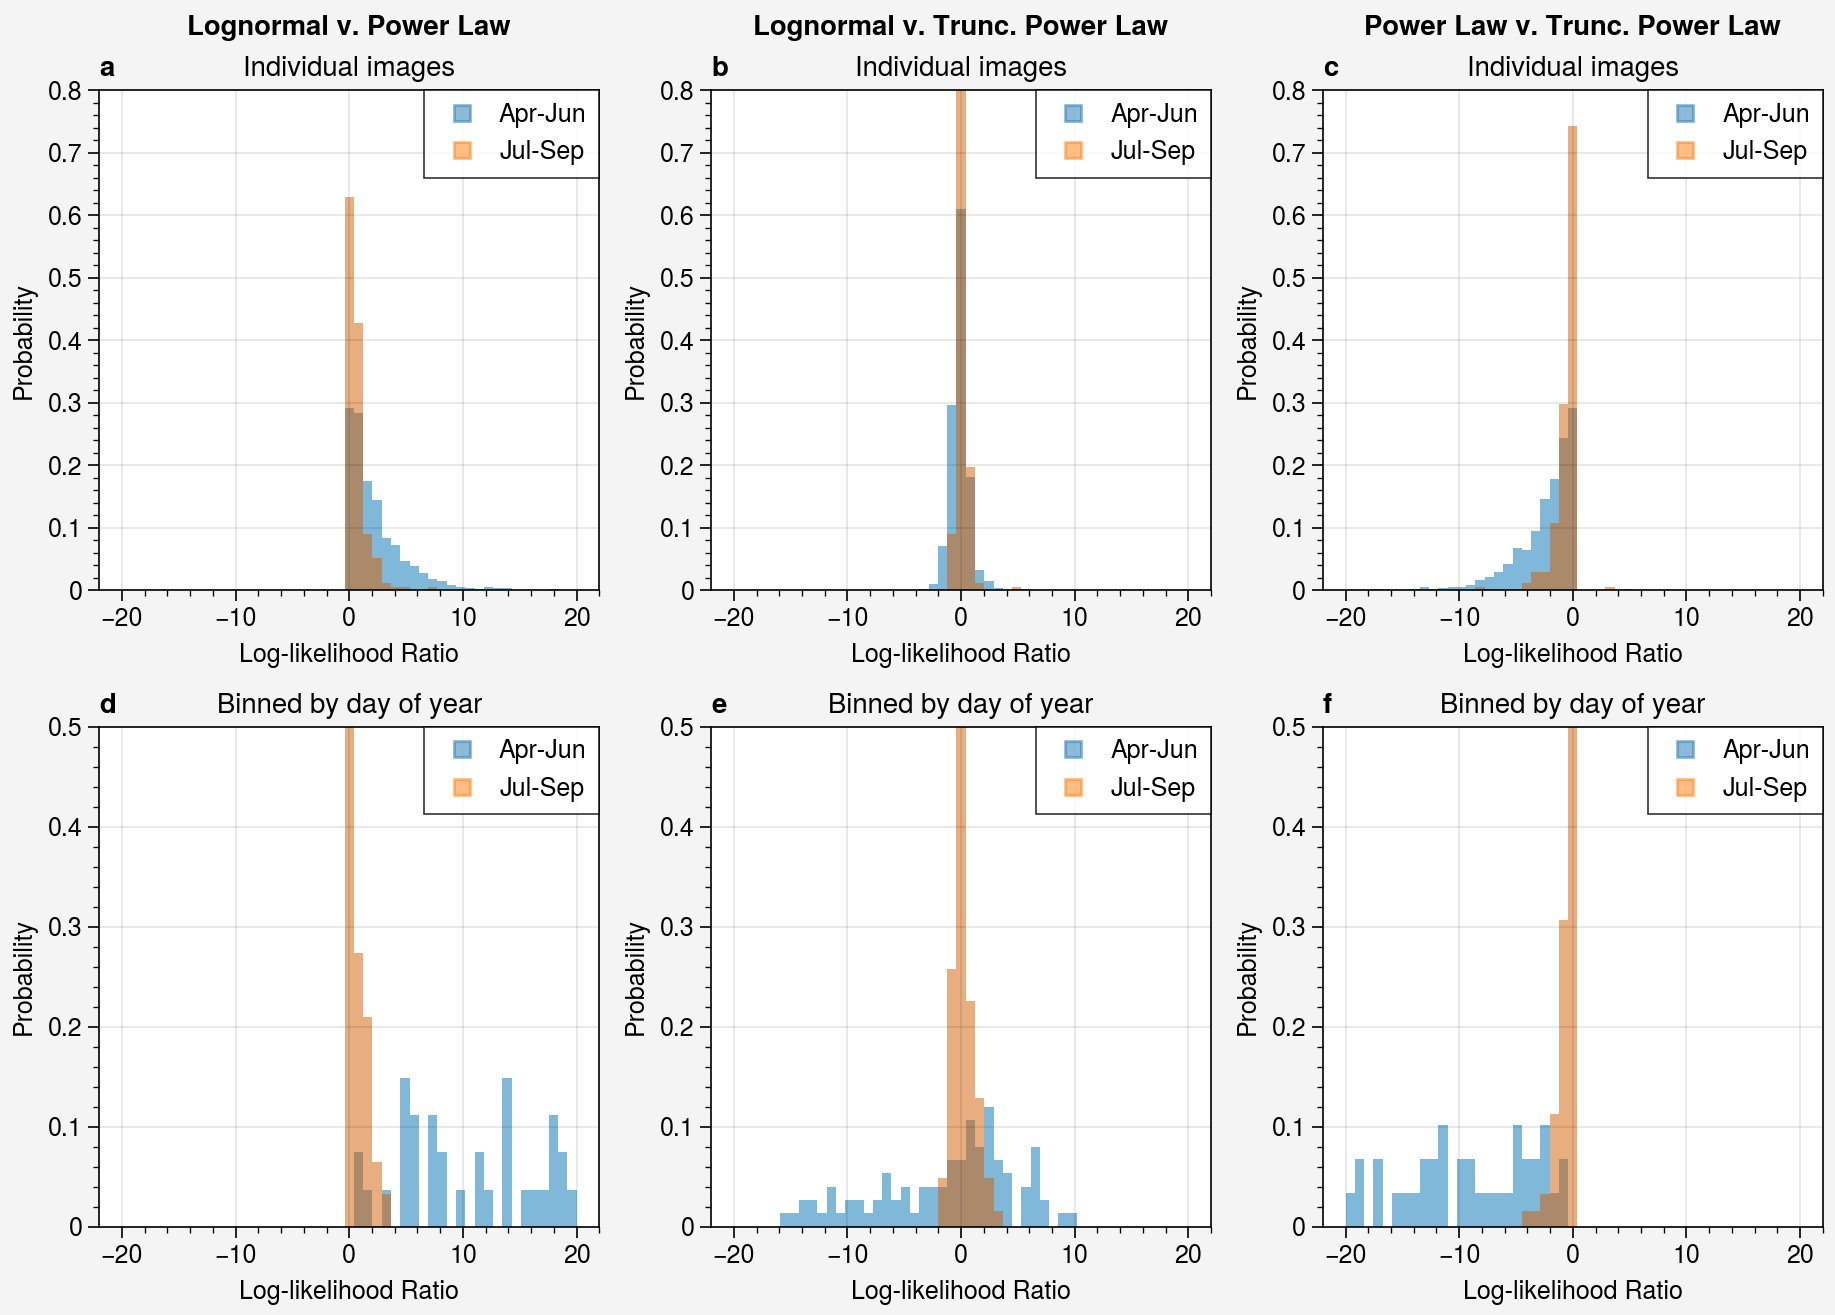

In [347]:
fig, axs = pplt.subplots(ncols=3, nrows=2, share=False)

for col, var in enumerate(['lr_PL_v_TPL', 'lr_PL_v_LN', 'lr_LN_v_TPL']):
    row = 0
    ax = axs[row, col]
    for idx in [results.datetime.dt.month <= 6, results.datetime.dt.month > 6]:
        ax.hist(results.loc[idx, var], alpha=0.5, density=True, bins=np.linspace(-20, 20, 50))
        ax.format(xlabel='Log-likelihood Ratio', title='Individual images', ylim=(0, 0.8), ylabel='Probability')
        
    h = [ax.plot([],[], color=c, alpha=0.5, m='s', lw=0) for c in ['tab:blue', 'tab:orange']]
    ax.legend(h, ['Apr-Jun', 'Jul-Sep'], loc='ur', ncols=1)
        
    row = 1
    ax = axs[row, col]
    for idx in [results_alt.doy <= pd.to_datetime('2020-06-30').dayofyear,
                results_alt.doy > pd.to_datetime('2020-06-30').dayofyear]:
        ax.hist(results_alt.loc[idx, var], alpha=0.5, density=True, bins=np.linspace(-20, 20, 50))
        ax.format(xlabel='Log-likelihood Ratio', title='Binned by day of year', ylabel='Probability')

    h = [ax.plot([],[], color=c, alpha=0.5, m='s', lw=0) for c in ['tab:blue', 'tab:orange']]
    ax.legend(h, ['Apr-Jun', 'Jul-Sep'], loc='ur', ncols=1)
fig.format(toplabels=['Lognormal v. Power Law', 'Lognormal v. Trunc. Power Law', 'Power Law v. Trunc. Power Law'],
           abc=True)
for ax in axs[row, :]:
    ax.format(ylim=(0, 0.5))
fig.save('../figures/fig05_log_likelihoods.pdf')
fig.save('../figures/fig05_log_likelihoods.png', dpi=300)

## False discovery rate procedure for multiple hypothesis testing (Bejamini-Hochberg procedure).

Sort the $p$ values for all tests, so the $p_k$ is the $k$th largest $p$ value. Let $m$ be the number of tests. Then for significance level $\alpha$, we consider all tests with 
$$P_k \leq \frac km \alpha$$
to be statistically significant. 


In [456]:
p = list(results['p_PL_v_TPL']) + list(results['p_PL_v_LN']) + list(results['p_LN_v_TPL']) + \
    list(results_alt['p_PL_v_TPL']) + list(results_alt['p_PL_v_LN']) + list(results_alt['p_LN_v_TPL'])
p.sort()
alpha = 0.01
test = np.array(p) < alpha*(np.arange(1, len(p)+1)/len(p))
alpha_equiv = max(np.array(p)[test])
print(alpha_equiv)

0.0004904847213833


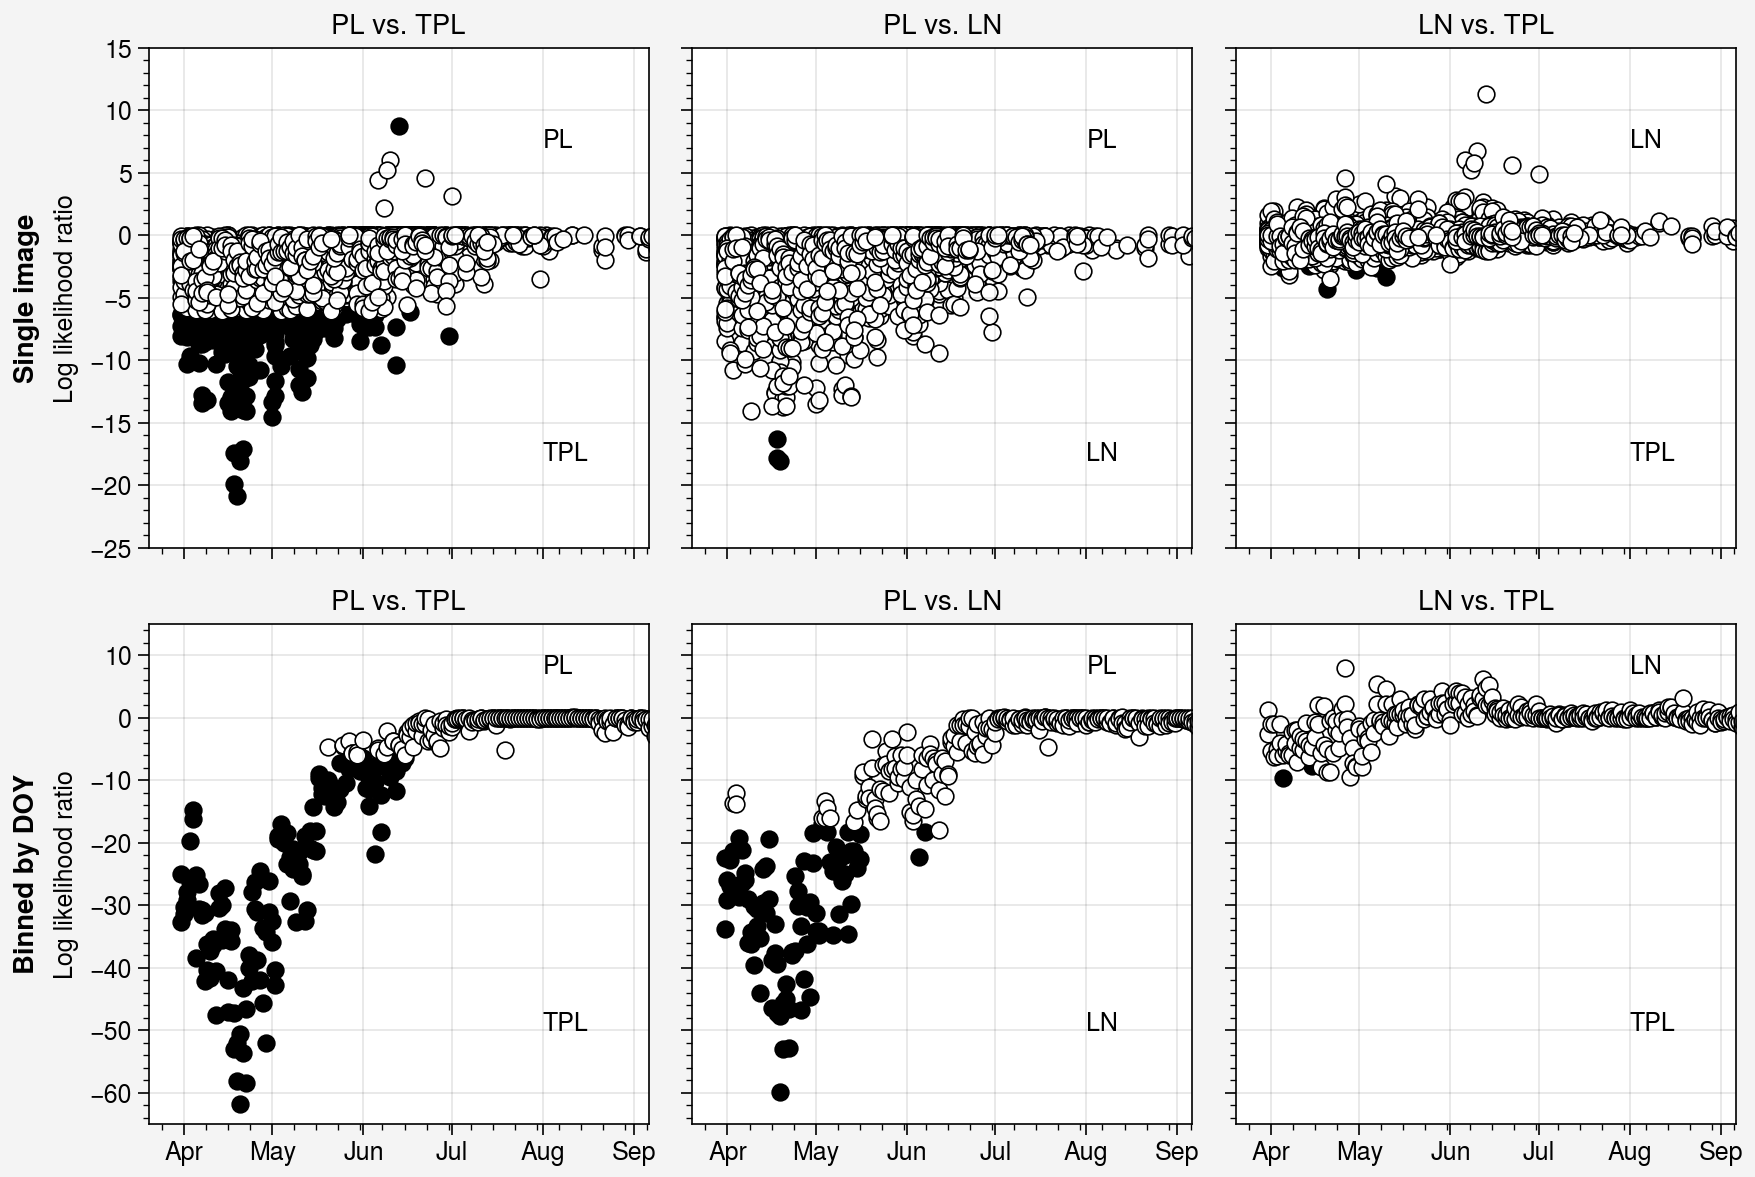

In [471]:
fig, axs = pplt.subplots(ncols=3, nrows=2, span=False)
for ax, comp in zip(axs[0,:], ['PL_v_TPL', 'PL_v_LN', 'LN_v_TPL']):
    ax.scatter(results.doy, results['lr_' + comp].where(results['p_' + comp] <= alpha_equiv),  marker='o', color='k')
    ax.scatter(results.doy, results['lr_' + comp].where(results['p_' + comp] > alpha_equiv),  marker='o', facecolor='w', edgecolor='k')
    ax.format(ylabel='Log likelihood ratio', title=comp.replace('v', 'vs.').replace('_', ' '), xlabel='', ylim=(-25, 15))
    ax.text(214, 7, comp.split('_')[0])
    ax.text(214, -18, comp.split('_')[2])
for ax, comp in zip(axs[1,:], ['PL_v_TPL', 'PL_v_LN', 'LN_v_TPL']):
    ax.scatter(results_alt.doy, results_alt['lr_' + comp].where(results_alt['p_' + comp] <= alpha_equiv),  marker='o', color='k')
    ax.scatter(results_alt.doy, results_alt['lr_' + comp].where(results_alt['p_' + comp] > alpha_equiv),  marker='o', facecolor='w', edgecolor='k')
    ax.format(ylabel='Log likelihood ratio', title=comp.replace('v', 'vs.').replace('_', ' '),
             xlocator=dr.dayofyear, xformatter=[d.strftime('%b') for d in dr], xlabel='',
              ylim=(-65, 15), xlim=(80, 250))
    ax.text(214, 7, comp.split('_')[0])
    ax.text(214, -50, comp.split('_')[2])
axs.format(leftlabels=['Single image', 'Binned by DOY'])    


For the single images, we see occasional significant tests early in the year. Log likelihoods rarely favor the power law. We see smaller differences toward the summer throughout. The log likelihoods show no preference between log normal and truncated power law. For the data binned by DOY, during the early part of the year both truncated power laws and lognormal power laws are significantly more likely than pure power laws; the likelihood ratios cannot distinguish between lognormal and truncated power law.

In [404]:
results['date'] = pd.to_datetime(results['date'])

## Example PDFs and CDFs

Showing the PDF and CCDF of the distributions -- use a representative day of year, and show
* light lines showing the range across the years
* dark line showing a single year, with the best fit next to it
* another line showing the fit with all the years grouped together

In [109]:
np.random.choice([date for date in dates if pd.to_datetime(date).month == 4])

numpy.datetime64('2017-04-03T13:55:35.000000000')

In [132]:
np.random.choice([date for date in dates if pd.to_datetime(date).month == 5])

numpy.datetime64('2012-05-31T11:49:23.000000000')

In [133]:
np.random.choice([date for date in dates if pd.to_datetime(date).month == 6])

numpy.datetime64('2005-06-14T13:48:38.000000000')

In [136]:
med_groups = df.groupby('datetime').filter(lambda x: len(x) > 100)
dates2 = np.unique(med_groups['datetime'])
sample2 = np.random.choice(dates, 100)
np.random.choice([date for date in dates2 if pd.to_datetime(date).month == 7])

numpy.datetime64('2007-07-13T13:55:44.000000000')

In [112]:
example_date = pd.to_datetime('2017-04-03T13:55:35')
example_date.dayofyear

93

In [137]:
np.random.choice([date for date in dates2 if pd.to_datetime(date).month == 8])

numpy.datetime64('2010-08-02T11:25:22.000000000')

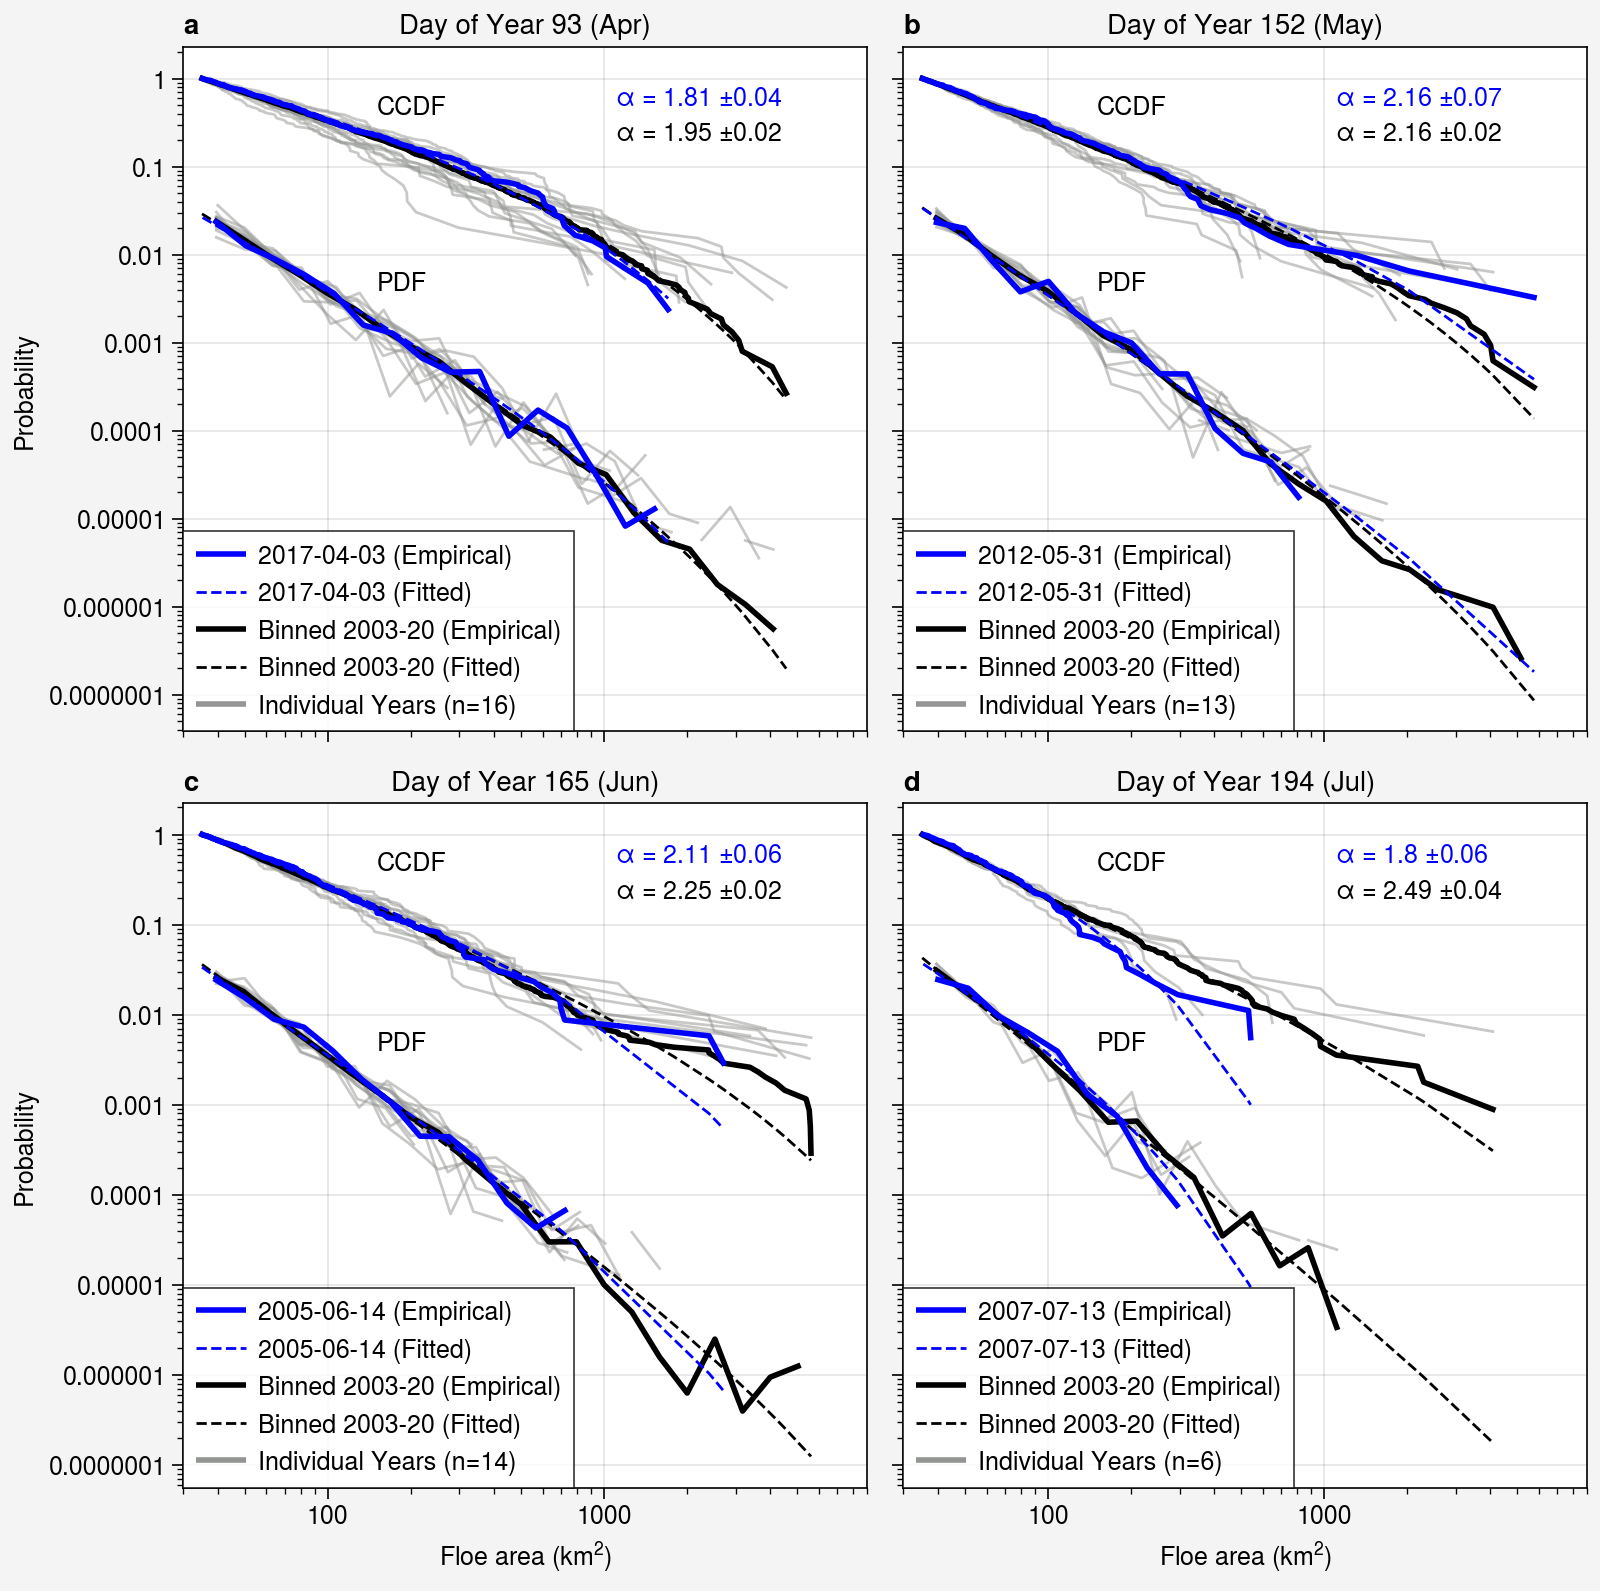

In [439]:
fig, axs = pplt.subplots(width=8, ncols=2, nrows=2, span=False)
# In case you want to try specifying an x max instead
xmax = None
for ax, example_date in zip(axs, [pd.to_datetime('2017-04-03T13:55:35'),
                                     pd.to_datetime('2012-05-31T11:49:23'),
                                     pd.to_datetime('2005-06-14T13:48:38'),
                                     pd.to_datetime('2007-07-13T13:55:44')]):

    satellite = df.loc[df.datetime == example_date].satellite.values[0]
    n = 0
    for year, group in df.groupby(df.datetime.dt.year):
        data = group.loc[(group.datetime.dt.dayofyear == example_date.dayofyear) & (group.satellite == satellite), 'area_adj_km']
        
        if len(data) > 100:
            fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
            fit.plot_pdf(color='gray', linewidth=1, alpha=0.5, ax=ax)
            fit.plot_ccdf(color='gray', linewidth=1, alpha=0.5, ax=ax)
            n += 1
            
    data = df.loc[(df.datetime.dt.dayofyear == example_date.dayofyear) & (df.satellite==satellite), 'area_adj_km']
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    
    fit.plot_pdf(color='k', linewidth=2, ax=ax)
    fit.plot_ccdf(color='k', linewidth=2, ax=ax)
    fit.truncated_power_law.plot_pdf(color='k', ax=ax, linestyle='--', lw=1)
    fit.truncated_power_law.plot_ccdf(color='k', linestyle='--', lw=1, ax=ax)  
    alpha_all = np.round(fit.truncated_power_law.alpha,2)
    se_all =  np.round((alpha_all - 1)/np.sqrt(len(data)),2)
    ax.text(1100, 0.2,'$\\alpha$ = ' + str(alpha_all) + ' $\pm$' + str(se_all), color='k')

    
    data=df.loc[df.datetime == example_date].area_adj_km
    fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
    alpha_one = np.round(fit.truncated_power_law.alpha,2)
    se_one = np.round((alpha_one - 1)/np.sqrt(len(data)),2)
    ax.text(1100, 0.5,'$\\alpha$ = ' + str(alpha_one) + ' $\pm$' + str(se_one), color='b')

    
    fit.plot_pdf(color='b', linewidth=2, ax=ax)
    fit.truncated_power_law.plot_pdf(color='b', ax=ax, linestyle='--', lw=1)
    fit.plot_ccdf(color='b', linewidth=2, ax=ax)
    fit.truncated_power_law.plot_ccdf(color='b', linestyle='--', lw=1, ax=ax)
    ax.format(xlabel = 'Floe area (km$^2$)', ylabel='Probability',
             xlim=(30, 9000), title='Day of Year ' + str(example_date.dayofyear) + ' (' + example_date.strftime('%b') + ')')
    
    
    ax.text(150, 0.4, 'CCDF')
    ax.text(150, 0.004, 'PDF')


    # ax.text(750,.55,'xmin = '+str(fit.xmin)+' km$^2$')
    # ax.text(750,.3,'xmax = '+str(np.round(np.amax(data),0))+' km$^2$')
    # ax.text(750,.18,'N = '+str(len(data[data > fit.xmin])))
    h = [ax.plot([],[],color=c, lw=lw, ls=ls) for c, lw, ls in zip(['b', 'b',  'k', 'k', 'gray'],
                                                                   [2, 1, 2, 1, 2, 1],
                                                                   ['-', '--', '-', '--', '-', '-'])]
    ax.legend(h, [example_date.strftime('%Y-%m-%d' + ' (Empirical)'),
               example_date.strftime('%Y-%m-%d' + ' (Fitted)'),
               'Binned 2003-20 (Empirical)',
                  'Binned 2003-20 (Fitted)',
                  'Individual Years (n=' + str(n) + ')'], loc='ll', order='F', ncols=1)

axs.format(abc=True)
fig.save('../figures/fig06_example_dates_fsd.pdf')
fig.save('../figures/fig06_example_dates_fsd.png', dpi=300)

## Tracked floes vs all floes
Checking whether the PDF and CCDF of the data are substantially different when we look at tracked floes only versus when we look at the full dataset.

SubplotGrid(nrows=1, ncols=1, length=1)

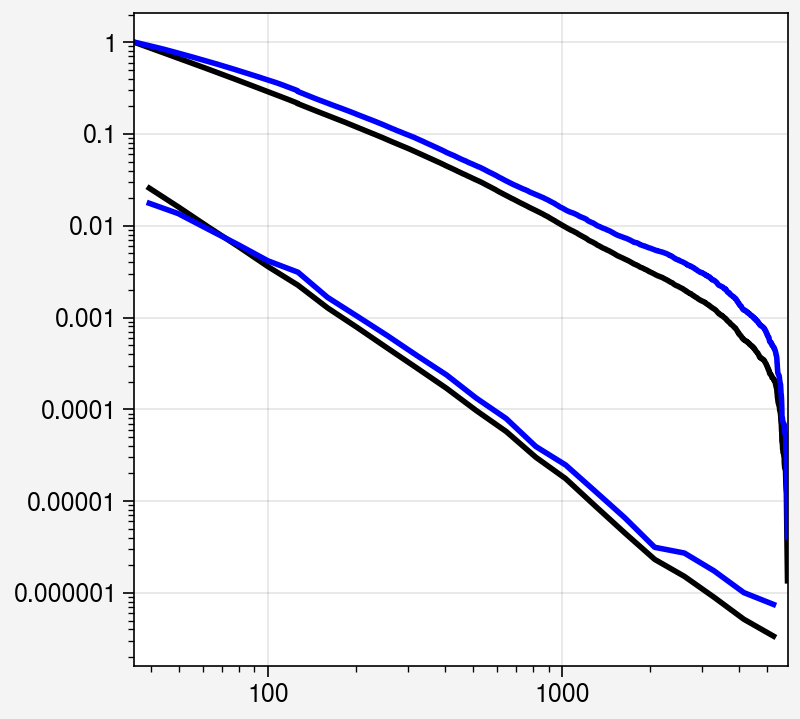

In [345]:
fig, ax = pplt.subplots(width=4)
data = df.area_adj_km
fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
fit.plot_pdf(color='k', linewidth=2, ax=ax)
fit.plot_ccdf(color='k', linewidth=2, ax=ax)

data = df.loc[(df.floe_id != 'unmatched')].area_adj_km
fit = powerlaw.Fit(data,xmin=35, xmax=xmax)
fit.plot_pdf(color='b', linewidth=2, ax=ax)
fit.plot_ccdf(color='b', linewidth=2, ax=ax)

TBD: Using QQ plots for goodness of fit tests

We'd need to get the parameters for the distribution we're comparing to, and think about how to aggregate over multiple days

Some alternate ideas:
* breaking it up by edge distance & coast distance
* pooling by day of year beofre calculating fit

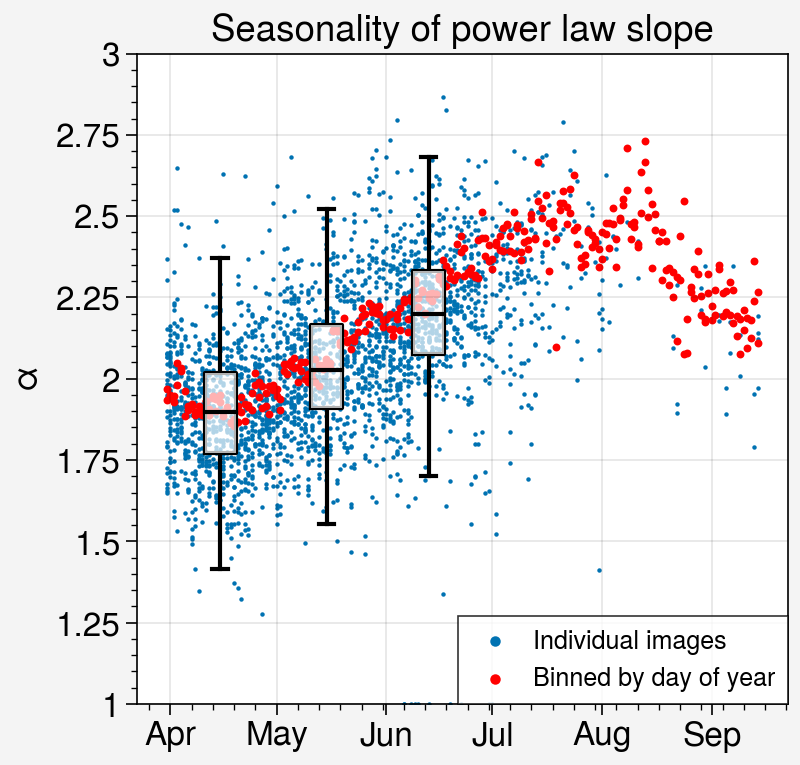

In [480]:
doy = results.groupby('month').mean()['doy']
fig, ax = pplt.subplots(width=4)
n_threshold = 1 #
month_threshold = 300
variable = 'alpha_tpl'
time_idx = (results.month != 3) & (results.month <= 9)
df_pivot = results.loc[time_idx & (results.n > n_threshold)].pivot_table(index='date', values=variable, columns='month')
month_counts = df_pivot.notnull().sum() 
month_idx = [m for m in month_counts.index if month_counts[m] > month_threshold]
_ = ax.box(doy[month_idx].values/30, df_pivot[month_idx], facecolor='w', alpha=0.7, zorder=1, lw=1.5, marker='')
_ = ax.scatter(results.loc[results.n > n_threshold].date.dt.dayofyear/30,
               results.loc[results.n > n_threshold, variable], marker='o', ms=1, zorder=0, label='Individual images')
_ = ax.scatter(results_alt.doy/30, results_alt[variable], marker='o', ms=5, zorder=0, color='r', label='Binned by day of year')

ax.format(ylim=(1, 3), xlocator=dr.dayofyear/30, xformatter=[d.strftime('%b') for d in dr],
          xlabel='', ylabel='$\\alpha$', title='Seasonality of power law slope', fontsize=12)
ax.legend(loc='lr', ncols=1, ms=10, fontsize=12)

# PDF for publication, PNG for slides
fig.save('../figures/fig07_fsd_slope.pdf', dpi=300)
fig.save('../figures/fig07_fsd_slope.png', dpi=300)

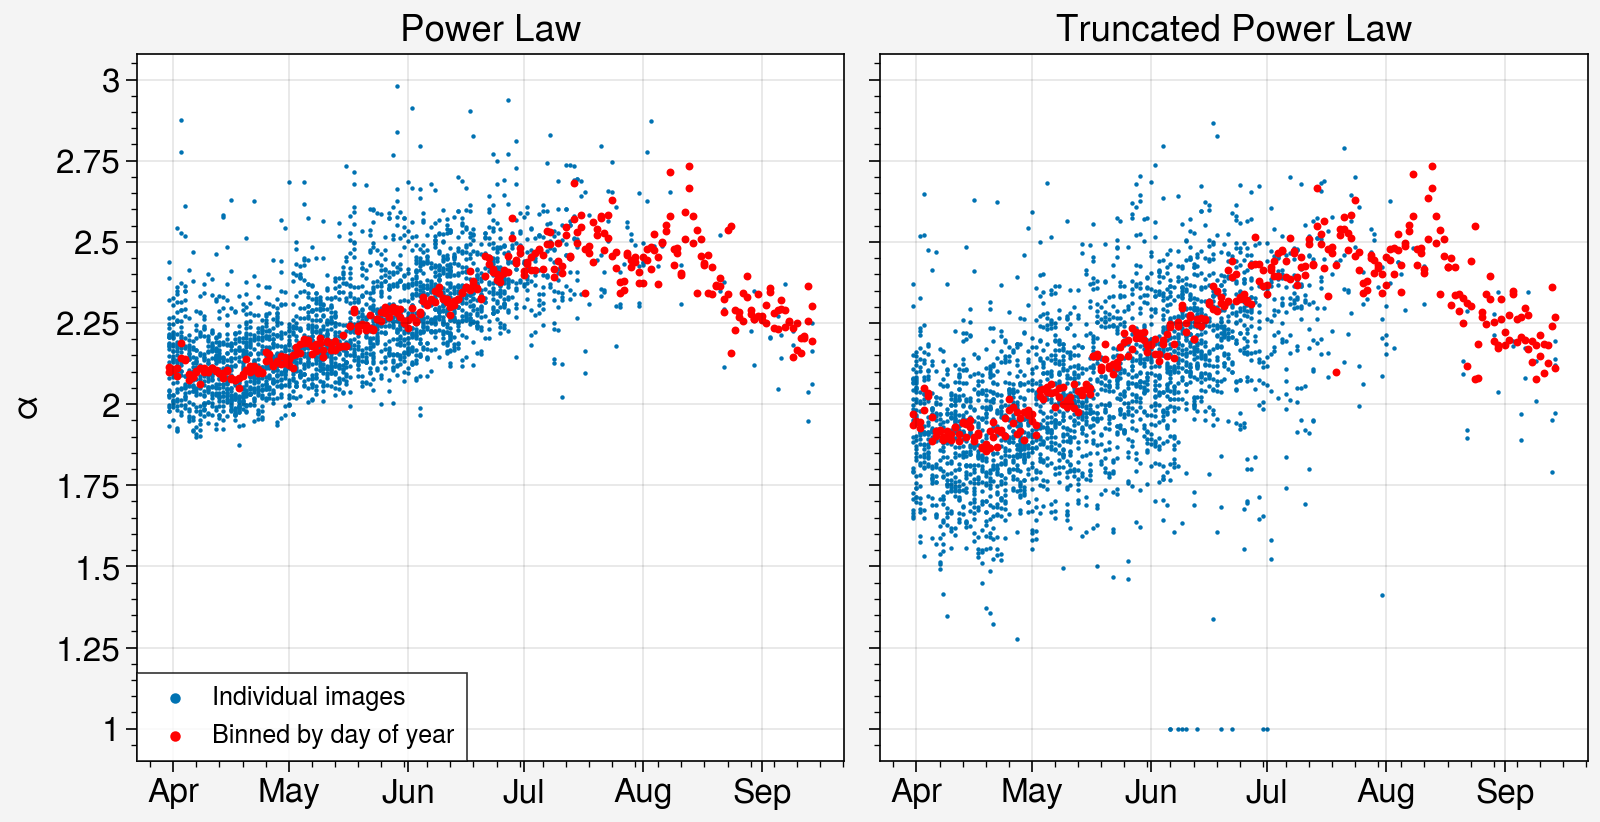

In [510]:

fig, axs = pplt.subplots(width=8, ncols=2, share=True)
min_n = 100
time_idx = (results.month != 3) & (results.month <= 9)
for ax, var, title in zip(axs, ['alpha', 'alpha_tpl'], ['Power Law', 'Truncated Power Law']):
    df_pivot = results.loc[time_idx & (results.n > min_n)].pivot_table(index='date', values=var, columns='month')
    month_counts = df_pivot.notnull().sum() 
    month_idx = [m for m in month_counts.index if month_counts[m] > 100]
    _ = ax.scatter(results.loc[results.n > min_n].date.dt.dayofyear/30, results.loc[results.n > min_n, var], marker='o', ms=1, zorder=0, label='Individual images')
    _ = ax.scatter(results_alt.doy/30, results_alt[var], marker='o', ms=5, zorder=0, color='r', label='Binned by day of year')
    
    ax.format(xlocator=dr.dayofyear/30, xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, title=title)
axs[0].format(ylabel='$\\alpha$')
axs[1].format(ylabel='$\\alpha$')
axs[0].legend(loc='ll', ncols=1, ms=10)
# axs[0].format(ylim=(-40, 10))
# axs[1].format(ylim=(0,6))
# fig.save('../figures/fsd_slope.png', dpi=300)

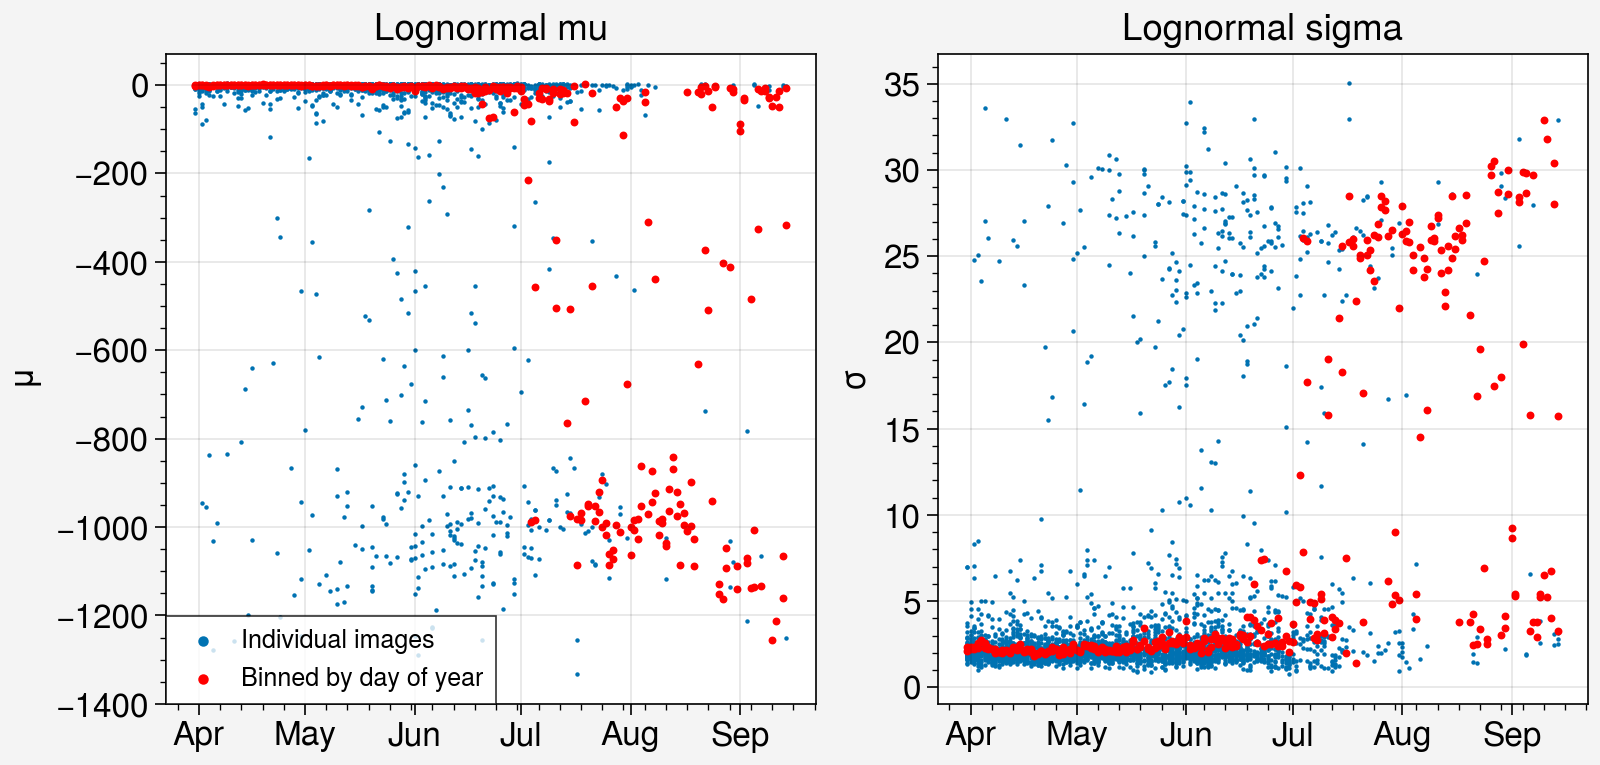

In [488]:

fig, axs = pplt.subplots(width=8, ncols=2, share=False, span=False)
min_n = 100
time_idx = (results.month != 3) & (results.month <= 9)
for ax, var, title in zip(axs, ['mu', 'sigma'], ['Lognormal mu', 'Lognormal sigma']):
    df_pivot = results.loc[time_idx & (results.n > min_n)].pivot_table(index='date', values=var, columns='month')
    month_counts = df_pivot.notnull().sum() 
    month_idx = [m for m in month_counts.index if month_counts[m] > 100]
    _ = ax.scatter(results.loc[results.n > min_n].date.dt.dayofyear/30, results.loc[results.n > min_n, var], marker='o', ms=1, zorder=0, label='Individual images')
    _ = ax.scatter(results_alt.doy/30, results_alt[var], marker='o', ms=5, zorder=0, color='r', label='Binned by day of year')
    
    ax.format(xlocator=dr.dayofyear/30, xformatter=[d.strftime('%b') for d in dr],
              xlabel='', fontsize=12, title=title)
axs[0].format(ylabel='$\mu$')
axs[1].format(ylabel='$\sigma$')
axs[0].legend(loc='ll', ncols=1, ms=10)

In [508]:
# results.loc[30]

In [ ]:
# TBD
# near_coast_results = []
# near_edge_results = []
# for year, df_year in df.groupby('year'):
#     for date, df_date in df_year.groupby('datetime'):
#         if len(df_date) > 100:
#             area = (np.sqrt(df_date.area_km) + 1.5)**2 # adjustment for the over dilation
#             fit = powerlaw.Fit(area, xmin=10)
#             alpha = fit.power_law.alpha
#             comp_powerlaw = fit.distribution_compare('lognormal', 'power_law')[0]
#             comp_exponential = fit.distribution_compare('lognormal', 'exponential')[0]
#             comp_pl_v_exp = fit.distribution_compare('power_law', 'exponential')[0]
#             near_coast_results.append([date, len(df_date), alpha, comp_powerlaw, comp_exponential, comp_pl_v_exp])
# results = pd.DataFrame(results, columns=['date', 'n', 'alpha', 'lr_LN_v_PL', 'lr_LN_v_EXP', 'lr_PL_v_EXP'])        

# notes

Updated FSD analysis
* Describe new data processing method in paper
* Describe area adjustment
* Power law vs lognormal

Discussion
Stern et al. reconciliation paper
- we don't have the issue of the largest floes being excluded by image size, however we also don't know how well the data samples the existing floes -- that will have to be its own paper
- 
Displacing and interpreting the results of the lognormal vs power law values

Rothrock and Thorndike 1984 introduced error estimation when sampling the FSD
We should point out that wave fraction has been shown to lead to a lognormal distribution, and that there is likely a shift in distributions that coincides with a shift between a fracture-based distribution change and a melt-rate based distribution change.

## Caveats
- Our method is repeated samples of floe sizes, across many images, rather than exhaustive calculation in a small set of images. Cautious comparison with prior studies. Future work to examine sampling. Assuming that sampling is similar across our dataset, then we can say that there is clear steepening through spring, and a likely shift in summer towards more shallow slopes. Our data shows that 

# Comparison to prior work
- Lu et al. 2008, slope of cumulative FSD steepens as ice edge is approached (summer)
- Paget et al. 2001 - slopes steepen towards edge (winter)
- Stern et al. 2018: slope of FSD steepens in spring as large floes break up
- Perovich and Jones - lateral melting would make the slope shallower at smaller floe sizes
- Stern et al. 2018b - some studies show shallower slopes for small floes, some steeper for small floes

Rejecting null hypothesis with K-S test of fitted distribution. D converges to 0 as n increases, so a large value of D is more likely to result in rejecting the null hypothesis with a large sample. I could make a plot with the data colored by whether the distribution is significantly different than the assumed distribution.

* Potential to build on Stern et al. 2018 work -- could we use their floe segmentation of MODIS imagery as a comparison point?


* Threshold for including image - 100 floes? or higher number?
Could do a simple bootstrap approach. For each increment of 10, resample alpha. Compute the percent error.